In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

from mlens.ensemble import SuperLearner

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression, SGDClassifier

from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

import optuna
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning



[MLENS] backend: threading


In [14]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)



In [20]:
train_df = pd.read_csv('../../../data/feature/final3.csv').sample(frac=1)
# test_df = pd.read_csv('../../../data/feature/cba_test.csv')



In [21]:
train_df.head()



,policy_term,policy_payment_mode,policy_status,main_holder_smoker_flag,main_holder_gender,total_sum_assuared,premium_value,payment_method,client_code,product_code,month_rank,total_rider_prem,total_rider_sum_assuared,children_count,current_age,completed_duration,completed_ratio,is_cross_sell
4586,180,-0.020976,0.335611,-0.210090,0.006204,1000000.0,72096.0,0.536784,13577,1,18,0.0,0,0,380,0,0.000000,1
4801,240,-0.020976,0.335611,0.018666,0.006204,450000.0,27084.0,-0.106502,19665,1,19,792.0,450000,0,585,0,0.000000,1
4686,180,0.097652,-0.198882,0.018666,0.006204,316090.0,47026.0,-0.106502,20966,1,18,1108.0,632180,0,268,30,0.166667,1
2812,180,0.048856,-0.198882,0.018666,0.006204,300000.0,20050.0,-0.106502,6387,1,5,0.0,0,0,482,29,0.161111,1
2442,180,0.097652,-0.198882,0.018666,0.006204,125000.0,10000.0,-0.106502,935,3,0,0.0,0,0,484,174,0.966667,1


In [22]:
X, y = train_df.iloc[:, :-1], train_df.iloc[:,-1]
#X_test = test_df.copy()
X, X_val, y, y_val = train_test_split(X, y, random_state=443, test_size=0.2, shuffle=False)



In [23]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X, y)
        preds = model.predict(X_val)
        if self.metric == 'acc':
            return accuracy_score(y_val, preds)
        else:
            return roc_auc_score(y_val, preds, average='macro')
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params



In [24]:
rf = RandomForestClassifier(
    random_state=666
)
rf.fit(X, y)
preds = rf.predict(X_val)

print('Random Forest accuracy: ', accuracy_score(y_val, preds))
print('Random Forest f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
rf_f1_params = optimizer.optimize()
rf_f1_params['random_state'] = 666
rf_f1 = RandomForestClassifier(**rf_f1_params)
rf_f1.fit(X, y)
preds = rf_f1.predict(X_val)

print('Optimized on F1 score')
print('Optimized Random Forest: ', accuracy_score(y_val, preds))
print('Optimized Random Forest f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
rf_acc_params = optimizer.optimize()
rf_acc_params['random_state'] = 666
rf_acc = RandomForestClassifier(**rf_acc_params)
rf_acc.fit(X, y)
preds = rf_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Random Forest: ', accuracy_score(y_val, preds))
print('Optimized Random Forest f1-score: ', f1_score(y_val, preds, average='macro'))



RandomForestClassifier(random_state=666)

Random Forest accuracy:  0.6997950819672131
Random Forest f1-score:  0.6989731308718651


RandomForestClassifier(max_depth=6, min_samples_leaf=6, n_estimators=28,
                       random_state=666)

Optimized on F1 score
Optimized Random Forest:  0.6967213114754098
Optimized Random Forest f1-score:  0.6962608765134598


RandomForestClassifier(max_depth=6, min_samples_leaf=6, n_estimators=28,
                       random_state=666)

Optimized on accuracy
Optimized Random Forest:  0.6967213114754098
Optimized Random Forest f1-score:  0.6962608765134598


In [25]:
xgb = XGBClassifier(
    random_state=666
)
xgb.fit(X, y)
preds = xgb.predict(X_val)

print('XGBoost accuracy: ', accuracy_score(y_val, preds))
print('XGBoost f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    model = XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
xgb_f1_params = optimizer.optimize()
xgb_f1_params['random_state'] = 666
xgb_f1 = XGBClassifier(**xgb_f1_params)
xgb_f1.fit(X, y)
preds = xgb_f1.predict(X_val)

print('Optimized on F1 score')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized XGBoost f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
xgb_acc_params = optimizer.optimize()
xgb_acc_params['random_state'] = 666
xgb_acc = XGBClassifier(**xgb_acc_params)
xgb_acc.fit(X, y)
preds = xgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized XGBoost f1-score: ', f1_score(y_val, preds, average='macro'))



[18:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              random_state=666, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

XGBoost accuracy:  0.6772540983606558
XGBoost f1-score:  0.6768847078310056
[18:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old beha

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.9987938625405559,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0028966463919712386, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=14, n_jobs=12,
              num_parallel_tree=1, random_state=666, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5043849183346505,
              tree_method='exact', validate_parameters=1, verbosity=None)

Optimized on F1 score
Optimized XGBoost accuracy:  0.7233606557377049
Optimized XGBoost f1-score:  0.7180458368106823
[18:53:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5430366664684859,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.011217705041542098, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=66, n_jobs=12, num_parallel_tree=1, random_state=666,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8014639496000667, tree_method='exact',
              validate_parameters=1, verbosity=None)

Optimized on accuracy
Optimized XGBoost accuracy:  0.7223360655737705
Optimized XGBoost f1-score:  0.7164174783825366


In [26]:
lgb = LGBMClassifier(
    random_state=666
)
lgb.fit(X, y)
preds = lgb.predict(X_val)

print('LightGBM accuracy: ', accuracy_score(y_val, preds))
print('LightGBM f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 3000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
lgb_f1_params = optimizer.optimize()
lgb_f1_params['random_state'] = 666
lgb_f1 = LGBMClassifier(**lgb_f1_params)
lgb_f1.fit(X, y)
preds = lgb_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))
print('Optimized LightGBM f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
lgb_acc_params = optimizer.optimize()
lgb_acc_params['random_state'] = 666
lgb_acc = LGBMClassifier(**lgb_acc_params)
lgb_acc.fit(X, y)
preds = lgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))
print('Optimized LightGBM f1-score: ', f1_score(y_val, preds, average='macro'))



LGBMClassifier(random_state=666)

LightGBM accuracy:  0.6967213114754098
LightGBM f1-score:  0.6962110505417591


LGBMClassifier(learning_rate=0.17992852443144047, max_depth=4,
               min_child_samples=21, n_estimators=76, num_leaves=1103,
               random_state=666)

Optimized on F1-score
Optimized LightGBM accuracy:  0.7192622950819673
Optimized LightGBM f1-score:  0.718335018537243


LGBMClassifier(learning_rate=0.012160763167613338, max_depth=5,
               min_child_samples=63, n_estimators=110, num_leaves=1264,
               random_state=666)

Optimized on accuracy
Optimized LightGBM accuracy:  0.7213114754098361
Optimized LightGBM f1-score:  0.7164342357123326


In [27]:
dt = DecisionTreeClassifier(
    random_state=666
)
dt.fit(X, y)
preds = dt.predict(X_val)

print('Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Decision Tree f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeClassifier(
        min_samples_split=min_samples_split, 
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
dt_f1_params = optimizer.optimize()
dt_f1_params['random_state'] = 666
dt_f1 = DecisionTreeClassifier(**dt_f1_params)
dt_f1.fit(X, y)
preds = dt_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Optimized Decision Tree f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
dt_acc_params = optimizer.optimize()
dt_acc_params['random_state'] = 666
dt_acc = DecisionTreeClassifier(**dt_acc_params)
dt_acc.fit(X, y)
preds = dt_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Optimized Decision Tree f1-score: ', f1_score(y_val, preds, average='macro'))



DecisionTreeClassifier(random_state=666)

Decision Tree accuracy:  0.6055327868852459
Decision Tree f1-score:  0.6053500816585884


DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.02423548560323563,
                       random_state=666)

Optimized on F1-score
Optimized Decision Tree accuracy:  0.7028688524590164
Optimized Decision Tree f1-score:  0.6990460149966613


DecisionTreeClassifier(max_depth=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.005545297402338636,
                       random_state=666)

Optimized on accuracy
Optimized Decision Tree accuracy:  0.7100409836065574
Optimized Decision Tree f1-score:  0.6974637859744243


In [28]:
bc = BaggingClassifier(
    random_state=666
)
bc.fit(X, y)
preds = bc.predict(X_val)

print('Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Bagging Classifier f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_samples = trial.suggest_int('max_samples', 1, 100)
    model = BaggingClassifier(
        n_estimators=n_estimators, 
        max_samples=max_samples, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
bc_f1_params = optimizer.optimize()
bc_f1_params['random_state'] = 666
bc_f1 = BaggingClassifier(**bc_f1_params)
bc_f1.fit(X, y)
preds = bc_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized Bagging Classifier f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
bc_acc_params = optimizer.optimize()
bc_acc_params['random_state'] = 666
bc_acc = BaggingClassifier(**bc_acc_params)
bc_acc.fit(X, y)
preds = bc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized Bagging Classifier f1-score: ', f1_score(y_val, preds, average='macro'))



BaggingClassifier(random_state=666)

Bagging Classifier accuracy:  0.6711065573770492
Bagging Classifier f1-score:  0.6691528917546948


BaggingClassifier(max_samples=100, n_estimators=200, random_state=666)

Optimized on F1-score
Optimized Bagging Classifier accuracy:  0.6936475409836066
Optimized Bagging Classifier f1-score:  0.6924461587913855


BaggingClassifier(max_samples=100, n_estimators=200, random_state=666)

Optimized on accuracy
Optimized Bagging Classifier accuracy:  0.6936475409836066
Optimized Bagging Classifier f1-score:  0.6924461587913855


In [29]:
knn = KNeighborsClassifier()
knn.fit(X, y)
preds = knn.predict(X_val)

print('KNN accuracy: ', accuracy_score(y_val, preds))
print('KNN f1-score: ', f1_score(y_val, preds, average='macro'))

sampler = TPESampler(seed=0)
def create_model(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 25)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    return model

optimizer = Optimizer('f1')
knn_f1_params = optimizer.optimize()
knn_f1 = KNeighborsClassifier(**knn_f1_params)
knn_f1.fit(X, y)
preds = knn_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))
print('Optimized KNN f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
knn_acc_params = optimizer.optimize()
knn_acc = KNeighborsClassifier(**knn_acc_params)
knn_acc.fit(X, y)
preds = knn_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))
print('Optimized KNN f1-score: ', f1_score(y_val, preds, average='macro'))



KNeighborsClassifier()

KNN accuracy:  0.5727459016393442
KNN f1-score:  0.5724186765309971


KNeighborsClassifier(n_neighbors=17)

Optimized on F1-score
Optimized KNN accuracy:  0.5881147540983607
Optimized KNN f1-score:  0.5880870792178996


KNeighborsClassifier(n_neighbors=17)

Optimized on accuracy
Optimized KNN accuracy:  0.5881147540983607
Optimized KNN f1-score:  0.5880870792178996


In [32]:
abc = AdaBoostClassifier(
    random_state=666
)
abc.fit(X, y)
preds = abc.predict(X_val)

print('AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('AdaBoost f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 1.0)
    model = AdaBoostClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
abc_f1_params = optimizer.optimize()
abc_f1_params['random_state'] = 666
abc_f1 = AdaBoostClassifier(**abc_f1_params)
abc_f1.fit(X, y)
preds = abc_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized AdaBoost f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
abc_acc_params = optimizer.optimize()
abc_acc_params['random_state'] = 666
abc_acc = AdaBoostClassifier(**abc_acc_params)
abc_acc.fit(X, y)
preds = abc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized AdaBoost f1-score: ', f1_score(y_val, preds, average='macro'))



AdaBoostClassifier(random_state=666)

AdaBoost accuracy:  0.6915983606557377
AdaBoost f1-score:  0.6912012495913706


AdaBoostClassifier(learning_rate=0.2852885027365509, n_estimators=102,
                   random_state=666)

Optimized on F1-score
Optimized AdaBoost accuracy:  0.7038934426229508
Optimized AdaBoost f1-score:  0.7032051828398924


AdaBoostClassifier(learning_rate=0.20064741556481025, n_estimators=146,
                   random_state=666)

Optimized on accuracy
Optimized AdaBoost accuracy:  0.7028688524590164
Optimized AdaBoost f1-score:  0.7021484375


In [33]:
et = ExtraTreesClassifier(
    random_state=666
)
et.fit(X, y)
preds = et.predict(X_val)

print('ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('ExtraTreesClassifier f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
et_f1_params = optimizer.optimize()
et_f1_params['random_state'] = 666
et_f1 = ExtraTreesClassifier(**et_f1_params)
et_f1.fit(X, y)
preds = et_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized ExtraTreesClassifier f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
et_acc_params = optimizer.optimize()
et_acc_params['random_state'] = 666
et_acc = ExtraTreesClassifier(**et_acc_params)
et_acc.fit(X, y)
preds = et_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized ExtraTreesClassifier f1-score: ', f1_score(y_val, preds, average='macro'))



ExtraTreesClassifier(random_state=666)

ExtraTreesClassifier accuracy:  0.6762295081967213
ExtraTreesClassifier f1-score:  0.6756288309360841


ExtraTreesClassifier(max_depth=6, n_estimators=87, random_state=666)

Optimized on F1-score
Optimized ExtraTreesClassifier accuracy:  0.6598360655737705
Optimized ExtraTreesClassifier f1-score:  0.6598003519248778


ExtraTreesClassifier(max_depth=6, n_estimators=85, random_state=666)

Optimized on accuracy
Optimized ExtraTreesClassifier accuracy:  0.6598360655737705
Optimized ExtraTreesClassifier f1-score:  0.659813209702345


In [34]:
kfold = KFold(n_splits=10, random_state=443)

xyz = []
accuracy = []
std = []
classifiers = ['Extra Tree Classifier', 'Ada Boost Classifier', 'K-Neighbors Classifier','Bagging Classifier', 'Decision Tree Classifier', 'Light-GBM Classifier', 'XGBoost Classifier', 'RandomForestClassifier']

models_f1 = [ExtraTreesClassifier(**et_f1_params),
            AdaBoostClassifier(**abc_f1_params),
            KNeighborsClassifier(**knn_f1_params),
            BaggingClassifier(**bc_f1_params),
            DecisionTreeClassifier(**dt_f1_params),
            LGBMClassifier(**lgb_f1_params),
            XGBClassifier(silent=True,**xgb_f1_params),
            RandomForestClassifier(**rf_f1_params)]

for model in models_f1:
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "roc_auc")
    xyz.append(cv_result.mean(axis=0))
    std.append(cv_result.std(axis=0))
    accuracy.append(cv_result)
cv_df=pd.DataFrame({'mean accuracy':xyz,'Std of accuracy':std},index=classifiers)
cv_df.head(8)



[18:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

,mean accuracy,Std of accuracy
Extra Tree Classifier,0.713714,0.022737
Ada Boost Classifier,0.732718,0.023638
K-Neighbors Classifier,0.591696,0.022914
Bagging Classifier,0.727743,0.026391
Decision Tree Classifier,0.716278,0.023648
Light-GBM Classifier,0.735619,0.023996
XGBoost Classifier,0.736181,0.022460
RandomForestClassifier,0.738172,0.022967


[Text(0, 0, 'Extra Tree Classifier'),
 Text(1, 0, 'Ada Boost Classifier'),
 Text(2, 0, 'K-Neighbors Classifier'),
 Text(3, 0, 'Bagging Classifier'),
 Text(4, 0, 'Decision Tree Classifier'),
 Text(5, 0, 'Light-GBM Classifier'),
 Text(6, 0, 'XGBoost Classifier'),
 Text(7, 0, 'RandomForestClassifier')]

Text(0, 0.5, 'Accuracy score')

Text(0.5, 1.0, 'Accuracy varivation with models')

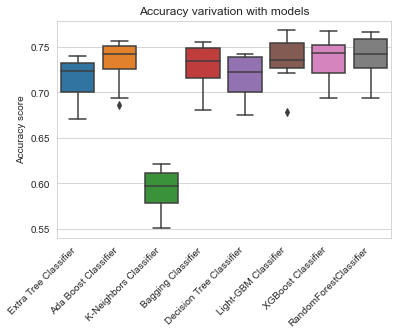

In [35]:
box = pd.DataFrame(accuracy,index=classifiers).T
sns.set_style('whitegrid')
ax = sns.boxplot(data=box)
ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
ax.set_ylabel("Accuracy score")
ax.set_title("Accuracy varivation with models")



Text(0.5, 1.0, 'Average CV Mean Accuracy')

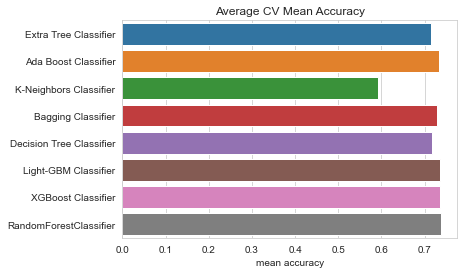

In [37]:
ax = sns.barplot(x=cv_df['mean accuracy'],y=cv_df.index)
ax.set_title('Average CV Mean Accuracy')



In [38]:
cv_st_df = cv_df.style.background_gradient()
cv_st_df
dfi.export(cv_st_df, 'cv_results.png')



,mean accuracy,Std of accuracy
Extra Tree Classifier,0.713714,0.022737
Ada Boost Classifier,0.732718,0.023638
K-Neighbors Classifier,0.591696,0.022914
Bagging Classifier,0.727743,0.026391
Decision Tree Classifier,0.716278,0.023648
Light-GBM Classifier,0.735619,0.023996
XGBoost Classifier,0.736181,0.022460
RandomForestClassifier,0.738172,0.022967
